# Mounts, installations and imports

In [ ]:
# Mount workspace
from google.colab import drive
drive.mount('/content/drive')
!unzip -o -u "/content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip" -d "."

Mounted at /content/drive
Archive:  /content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip
   creating: ./visualization/
  inflating: ./visualization/visualization.py  
   creating: ./preprocessors/
  inflating: ./preprocessors/loaders.py  
  inflating: ./preprocessors/features.py  
 extracting: ./Makefile              
   creating: ./utils/
  inflating: ./utils/constants.py    
  inflating: ./utils/utils.py        
   creating: ./models/
   creating: ./models/LLM/
  inflating: ./models/LLM/gpt2.py    
  inflating: ./models/LLM/DistilBert.py  
  inflating: ./models/LLM/BART.py    
  inflating: ./models/LLM/llama.py   
  inflating: ./models/NN.py          
   creating: ./models/RNN/
  inflating: ./models/RNN/lstm.py    
   creating: ./evaluators/
  inflating: ./evaluators/evaluators.py  
  inflating: ./preprocessing.py      
   creating: ./Data/
   creating: ./Data/raw_data/
   creating: ./Data/raw_data/Amazon/
  inflating: ./Data/raw_data/Amazo

In [ ]:
# # installations
# !pip uninstall -y transformers
# !pip install git+https://github.com/huggingface/transformers
!pip install stormtrooper
!pip install datasets
! pip install -U accelerate
! pip install -U transformers
!pip install evaluate
! pip install optuna
! pip install ray[tune]

  Preparing metadata (setup.py) ... done
  Created wheel for thefuzz: filename=thefuzz-0.18.0-py2.py3-none-any.whl size=18200 sha256=47cdbddf316246a915b5ba8c09be8dd5b1cc34ba124efb1f7f34e52c6f7589e6
  Stored in directory: /root/.cache/pip/wheels/8f/5b/ba/9b1a261ddd5216f10d8c6b14007d5db4b1aa16a4556d682031
Successfully built thefuzz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl 

In [ ]:
# Imports
# external imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer

# internal imports
from preprocessors import loaders
from utils import constants
from utils import utils
from visualization import visualization
from evaluators import evaluators
from models.LLM import gpt2

# Yelp Dataset

## Load dataset

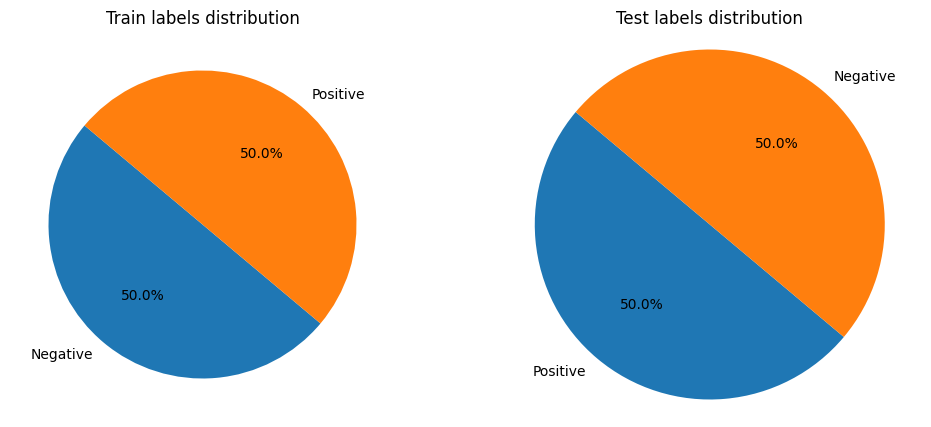

In [ ]:
yelp_train_df, yelp_test_df = loaders.load_raw_data(constants.DatasetYelp, root_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis")
visualization.plot_label_distribution(yelp_train_df, yelp_test_df)

In [ ]:
yelp_train_df[constants.ColumnLabel].replace({1: 0, 2: 1}, inplace=True)
yelp_test_df[constants.ColumnLabel].replace({1: 0, 2: 1}, inplace=True)
yelpTrainDataset, yelpTestDataset = datasets.Dataset.from_pandas(yelp_train_df.dropna()).rename_column("Text", "text").rename_column("Label", "labels"), datasets.Dataset.from_pandas(yelp_test_df.dropna()).rename_column("Text", "text").rename_column("Label", "labels")

## Model Initialization

In [ ]:
pretrained_llm_model = "distilbert/distilbert-base-uncased"
model_name = "DistilBert_FineTunedClassifier"
model_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Models/DistilBert_Yelp"

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
yelpTrainDataset.shape

(560000, 2)

In [ ]:


tokenizer = AutoTokenizer.from_pretrained(pretrained_llm_model, use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(pretrained_llm_model, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset, test_dataset =  yelpTrainDataset.shard(num_shards=50, index=1), yelpTestDataset.shard(num_shards=50, index=1)
preprocessor = lambda x: tokenizer(text=x["text"], truncation=True, padding=True, max_length=512)
def preprocessor(x):
  if not x['text']:
    print(x['text'])
  return tokenizer(x['text'], truncation=True, padding=True, max_length=512)
train_dataset = train_dataset.map(preprocessor, batched=False)
test_dataset = test_dataset.map(preprocessor, batched=False)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['labels', 'text', 'input_ids', 'attention_mask'],
    num_rows: 11200
})

In [ ]:
batch_size = 16
args = TrainingArguments(
    output_dir = model_path,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(pretrained_llm_model, num_labels=2)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255500,0.162093,0.947368
2,0.136700,0.216693,0.947368
3,0.053400,0.249952,0.944737
4,0.030500,0.281463,0.951316
5,0.013300,0.293601,0.947368


TrainOutput(global_step=3500, training_loss=0.089288179397583, metrics={'train_runtime': 774.2601, 'train_samples_per_second': 72.327, 'train_steps_per_second': 4.52, 'total_flos': 6658618679661120.0, 'train_loss': 0.089288179397583, 'epoch': 5.0})

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2024-04-11 22:43:01,215] A new study created in memory with name: no-name-82886b57-a8a0-418e-889c-773ff3e787be
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W 2024-04-11 22:43:01,883] Trial 0 failed with parameters: {'learning_rate': 2.1237164522761165e-05, 'num_train_epochs': 2, 'seed': 34, 'per_device_train_batch_size': 8} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 34.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 20.38 MiB is free. Process 26660 has 15.75 GiB memory in use. Of the allocated memory 15.27 GiB is allocated by PyTorch, and 118.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated

OutOfMemoryError: CUDA out of memory. Tried to allocate 34.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 20.38 MiB is free. Process 26660 has 15.75 GiB memory in use. Of the allocated memory 15.27 GiB is allocated by PyTorch, and 118.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
best_run

BestRun(run_id='5', objective=0.8661538461538462, hyperparameters={'learning_rate': 4.75233455716045e-05, 'num_train_epochs': 1, 'seed': 26, 'per_device_train_batch_size': 16}, run_summary=None)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.325600,0.319298,0.866154


TrainOutput(global_step=1875, training_loss=0.35065194905598956, metrics={'train_runtime': 195.9739, 'train_samples_per_second': 153.077, 'train_steps_per_second': 9.568, 'total_flos': 1639645497735036.0, 'train_loss': 0.35065194905598956, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.2814626097679138,
 'eval_accuracy': 0.9513157894736842,
 'eval_runtime': 3.351,
 'eval_samples_per_second': 226.797,
 'eval_steps_per_second': 14.324,
 'epoch': 5.0}

In [ ]:
trainer.save_model(output_dir=model_path)

In [ ]:
from transformers import pipeline

In [ ]:
c = pipeline("text-classification", model=model_path, device=0, tokenizer=tokenizer, max_length=512, truncation=True)

In [ ]:
i = 1232
text, label = yelp_train_df.loc[i]['Text'], yelp_train_df.loc[i]['Label']
print(c(text), label)
# pipe = pipeline("text-classification", model=model, tokenizer=model_path, )

[{'label': 'LABEL_0', 'score': 0.9995433688163757}] 0


"In general I do like Shake N' Steak, but this location is a hit or miss location!  You never know what kind of quality or service you're going to find here.  A friend and myself went a few weeks back after a movie and it had to be one of the worst trips there EVER!  You can't entirely blame the waitress since she was the only one there for the entire place...poor scheduling on the manager's part. However, while she can't be accountable for the slooooow service, she was accountable for both orders being incorrect.  The burgers were over cooked and the fries were soggie and the milkshake was runny at best...\\n\\nBy far my worst visit to Steak n' Shake!"